In [1]:
#venv: MLEnv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
from math import sqrt

import sqlite3
import warnings
warnings.filterwarnings('ignore')

import datetime
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns; sns.set_theme(color_codes=True)
sns.set_context("paper")


In [2]:
print(tf.__version__)

2.8.0


In [3]:
conn = sqlite3.connect(r'/Users/rosaicelaroman/Desktop/portfolio_work/earthquake_modeling/Database/db/earthquake_db')
print("Connected to database...")

Connected to database...


In [4]:
model_df = pd.read_sql_query("SELECT * FROM earthquake_raw", conn)
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06T01:42:39.855Z,37.3840,-117.107500,1.10,1.30,ml,8.0,149.46,0.87500,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.10,0.290,4.0,automatic,nn,nn
1,2022-01-06T01:31:33.698Z,38.1810,-117.818000,7.30,1.40,ml,11.0,154.64,0.11900,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.00,0.460,5.0,automatic,nn,nn
2,2022-01-06T01:24:20.083Z,61.3407,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
3,2022-01-06T01:15:15.851Z,62.8703,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
4,2022-01-06T01:10:44.629Z,64.0145,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33889,2022-02-15T19:12:23.740Z,39.4215,-110.312333,-1.56,1.83,md,9.0,194.00,0.01022,0.1200,...,2022-02-15T19:51:17.520Z,"15 km SSE of Sunnyside, Utah",earthquake,0.63,0.36,0.324,7.0,reviewed,uu,uu
33890,2022-02-15T19:04:27.070Z,38.8250,-122.797167,2.68,0.41,md,25.0,44.00,0.01021,0.0300,...,2022-02-17T09:24:12.854Z,"6km NNW of The Geysers, CA",earthquake,0.18,0.28,0.129,3.0,reviewed,nc,nc
33891,2022-02-15T19:00:38.627Z,38.5375,-119.382100,0.00,1.40,ml,6.0,179.74,0.05500,0.1995,...,2022-02-16T02:37:07.010Z,"8 km ENE of Walker, California",earthquake,NaN,0.00,0.280,3.0,reviewed,nn,nn
33892,2022-02-15T18:52:46.384Z,55.3724,-159.286100,15.00,1.80,ml,NaN,NaN,NaN,0.5500,...,2022-03-05T17:45:05.111Z,"60 km SSE of Ivanof Bay, Alaska",earthquake,NaN,0.40,NaN,NaN,reviewed,ak,ak


In [5]:
model_df['time'] = pd.to_datetime(model_df['time'])
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06 01:42:39.855000+00:00,37.3840,-117.107500,1.10,1.30,ml,8.0,149.46,0.87500,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.10,0.290,4.0,automatic,nn,nn
1,2022-01-06 01:31:33.698000+00:00,38.1810,-117.818000,7.30,1.40,ml,11.0,154.64,0.11900,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.00,0.460,5.0,automatic,nn,nn
2,2022-01-06 01:24:20.083000+00:00,61.3407,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
3,2022-01-06 01:15:15.851000+00:00,62.8703,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
4,2022-01-06 01:10:44.629000+00:00,64.0145,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33889,2022-02-15 19:12:23.740000+00:00,39.4215,-110.312333,-1.56,1.83,md,9.0,194.00,0.01022,0.1200,...,2022-02-15T19:51:17.520Z,"15 km SSE of Sunnyside, Utah",earthquake,0.63,0.36,0.324,7.0,reviewed,uu,uu
33890,2022-02-15 19:04:27.070000+00:00,38.8250,-122.797167,2.68,0.41,md,25.0,44.00,0.01021,0.0300,...,2022-02-17T09:24:12.854Z,"6km NNW of The Geysers, CA",earthquake,0.18,0.28,0.129,3.0,reviewed,nc,nc
33891,2022-02-15 19:00:38.627000+00:00,38.5375,-119.382100,0.00,1.40,ml,6.0,179.74,0.05500,0.1995,...,2022-02-16T02:37:07.010Z,"8 km ENE of Walker, California",earthquake,NaN,0.00,0.280,3.0,reviewed,nn,nn
33892,2022-02-15 18:52:46.384000+00:00,55.3724,-159.286100,15.00,1.80,ml,NaN,NaN,NaN,0.5500,...,2022-03-05T17:45:05.111Z,"60 km SSE of Ivanof Bay, Alaska",earthquake,NaN,0.40,NaN,NaN,reviewed,ak,ak


In [6]:
#adding column of converted time to datetime
model_df['Unix Time'] = pd.to_datetime(model_df['time']).astype(int)/10**9
model_df.head(5)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,Unix Time
0,2022-01-06 01:42:39.855000+00:00,37.3840,-117.1075,1.1,1.3,ml,8.0,149.46,0.875,0.2175,...,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.1,0.29,4.0,automatic,nn,nn,1.641433e+09
1,2022-01-06 01:31:33.698000+00:00,38.1810,-117.8180,7.3,1.4,ml,11.0,154.64,0.119,0.1017,...,"34 km SE of Mina, Nevada",earthquake,NaN,2.0,0.46,5.0,automatic,nn,nn,1.641433e+09
2,2022-01-06 01:24:20.083000+00:00,61.3407,-149.8852,30.0,1.5,ml,NaN,NaN,NaN,0.7500,...,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.2,NaN,NaN,automatic,ak,ak,1.641432e+09
3,2022-01-06 01:15:15.851000+00:00,62.8703,-150.7625,111.3,2.1,ml,NaN,NaN,NaN,0.3200,...,"41 km N of Petersville, Alaska",earthquake,NaN,0.8,NaN,NaN,automatic,ak,ak,1.641432e+09
4,2022-01-06 01:10:44.629000+00:00,64.0145,-148.7657,1.9,1.5,ml,NaN,NaN,NaN,0.7200,...,"17 km E of Ferry, Alaska",earthquake,NaN,0.6,NaN,NaN,automatic,ak,ak,1.641431e+09


In [7]:
#drop columns not needed
cleaned_df = model_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_df

,latitude,longitude,depth,mag,Unix Time
0,37.3840,-117.107500,1.10,1.30,1.641433e+09
1,38.1810,-117.818000,7.30,1.40,1.641433e+09
2,61.3407,-149.885200,30.00,1.50,1.641432e+09
3,62.8703,-150.762500,111.30,2.10,1.641432e+09
4,64.0145,-148.765700,1.90,1.50,1.641431e+09
...,...,...,...,...,...
33889,39.4215,-110.312333,-1.56,1.83,1.644952e+09
33890,38.8250,-122.797167,2.68,0.41,1.644952e+09
33891,38.5375,-119.382100,0.00,1.40,1.644952e+09
33892,55.3724,-159.286100,15.00,1.80,1.644951e+09


In [8]:
cleaned_df.isnull().sum()

latitude     0
longitude    0
depth        0
mag          6
Unix Time    0
dtype: int64

In [9]:
cleaned_df_dropped = cleaned_df.dropna()

In [10]:
cleaned_df_dropped = cleaned_df_dropped.rename(columns={'latitude':'label'})
cleaned_df_dropped

,label,longitude,depth,mag,Unix Time
0,37.3840,-117.107500,1.10,1.30,1.641433e+09
1,38.1810,-117.818000,7.30,1.40,1.641433e+09
2,61.3407,-149.885200,30.00,1.50,1.641432e+09
3,62.8703,-150.762500,111.30,2.10,1.641432e+09
4,64.0145,-148.765700,1.90,1.50,1.641431e+09
...,...,...,...,...,...
33889,39.4215,-110.312333,-1.56,1.83,1.644952e+09
33890,38.8250,-122.797167,2.68,0.41,1.644952e+09
33891,38.5375,-119.382100,0.00,1.40,1.644952e+09
33892,55.3724,-159.286100,15.00,1.80,1.644951e+09


In [11]:
train_dataset = cleaned_df_dropped.sample(frac=0.8, random_state=0)
test_dataset = cleaned_df_dropped.drop(train_dataset.index)

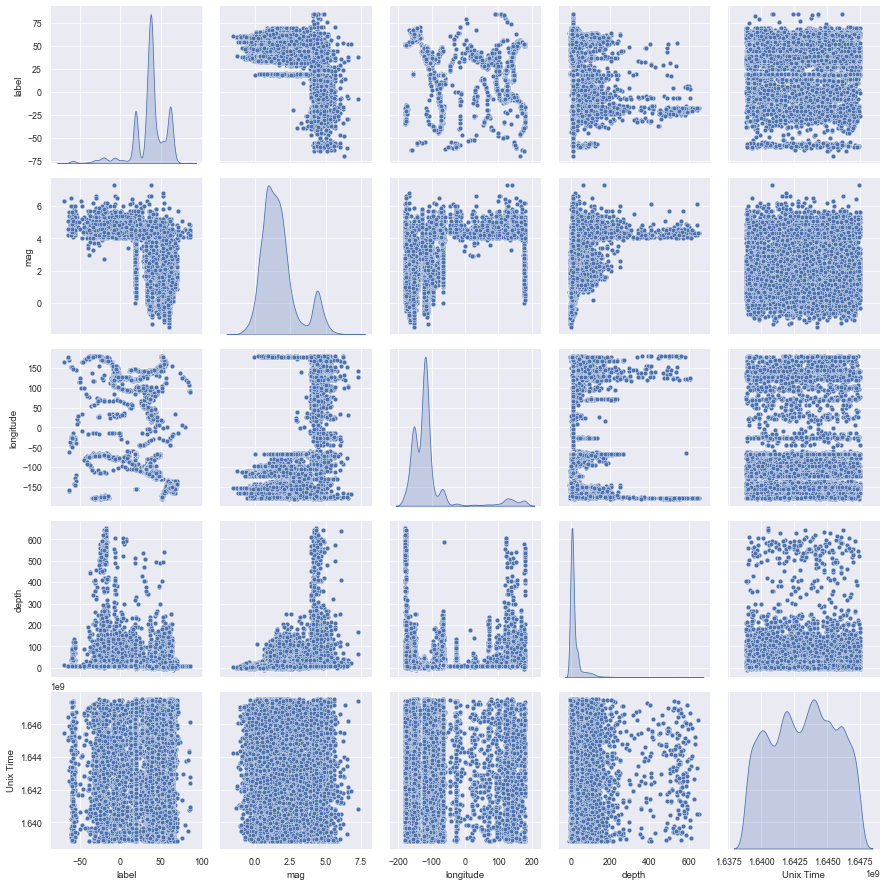

In [13]:
sns.pairplot(train_dataset[['label', 'mag', 'longitude', 'depth', 'Unix Time']], diag_kind='kde')

In [14]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
label,27110.0,3.624691e+01,2.020801e+01,-6.978250e+01,3.333479e+01,3.818500e+01,4.619767e+01,8.537330e+01
longitude,27110.0,-1.074725e+02,7.245246e+01,-1.799985e+02,-1.498565e+02,-1.212682e+02,-1.156051e+02,1.799901e+02
depth,27110.0,2.307089e+01,5.378177e+01,-1.000000e+01,3.390000e+00,8.990000e+00,1.842000e+01,6.538700e+02
mag,27110.0,1.723471e+00,1.276460e+00,-1.490000e+00,8.500000e-01,1.480000e+00,2.160000e+00,7.300000e+00
Unix Time,27110.0,1.643192e+09,2.427954e+06,1.638842e+09,1.641200e+09,1.643297e+09,1.645199e+09,1.647541e+09


In [15]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('label')
test_labels = test_features.pop('label')

In [16]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
label,3.624691e+01,2.020801e+01
longitude,-1.074725e+02,7.245246e+01
depth,2.307089e+01,5.378177e+01
mag,1.723471e+00,1.276460e+00
Unix Time,1.643192e+09,2.427954e+06


In [17]:
allset = np.array(train_features)

allset_normalizer = layers.Normalization(axis=-1)
allset_normalizer.adapt(allset)

2022-03-30 21:23:38.501599: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:

def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu', input_shape=(4,)),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001), metrics=['mae'])
  return model

In [20]:
dnn_model = build_and_compile_model(allset_normalizer)

In [21]:
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________


In [22]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=200)

CPU times: user 2min 46s, sys: 45.9 s, total: 3min 31s
Wall time: 1min 59s


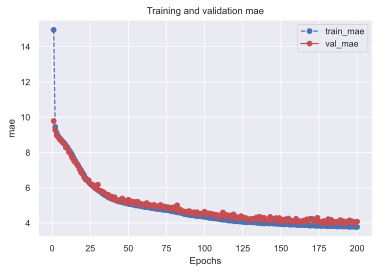

In [23]:
#following example: https://towardsdatascience.com/3-ways-to-create-a-machine-learning-model-with-keras-and-tensorflow-2-0-de09323af4d3
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()


# val_metrics = history.history['val_'+metric]
# print(val_metrics)
plot_metric(history, 'mae')

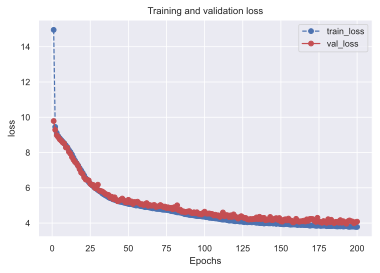

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()


# val_metrics = history.history['val_'+metric]
# print(val_metrics)
plot_metric(history, 'loss')

In [25]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = dnn_model.evaluate(test_features, test_labels)
print("test loss, test mae:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = dnn_model.predict(test_features[:])
print("predictions shape:", predictions.shape)

Evaluate on test data
212/212 [==============================] - 0s 1ms/step - loss: 3.9179 - mae: 3.9179
test loss, test mae: [3.917928695678711, 3.917928695678711]
Generate predictions for 3 samples
predictions shape: (6778, 1)


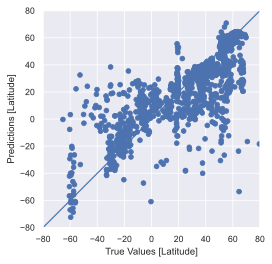

In [28]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Latitude]')
plt.ylabel('Predictions [Latitude]')
lims = [-80, 80]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

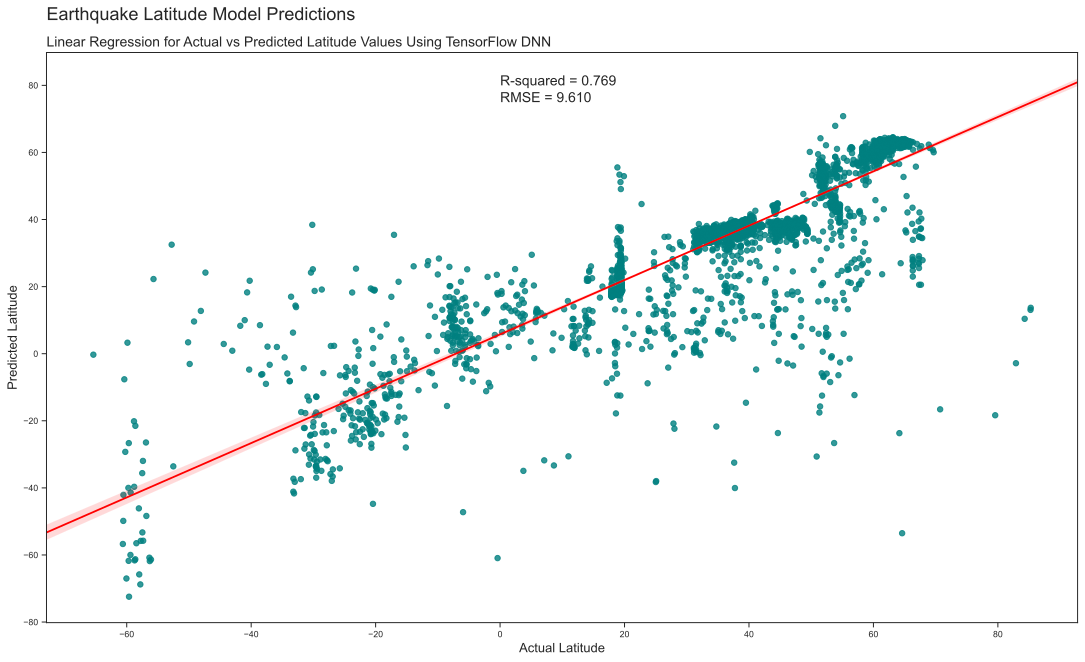

In [30]:
from sklearn.metrics import r2_score, mean_squared_error
#plot actual vs predicted values
x = np.array(test_labels)
y = np.array(test_predictions)
test_mse = mean_squared_error(test_labels,test_predictions)
rmse = sqrt(test_mse)

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'teal'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Latitude', fontsize=13)
plt.xlabel('Actual Latitude',  fontsize=13)
# Bigger title
plt.suptitle('Earthquake Latitude Model Predictions', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Latitude Values Using TensorFlow DNN', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(test_labels, test_predictions)), (0, 80),  fontsize=14)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 75), fontsize=14)

fig.savefig('../static/images/NN_lat_linear_sns.png', bbox_inches='tight',dpi=600)
plt.show()

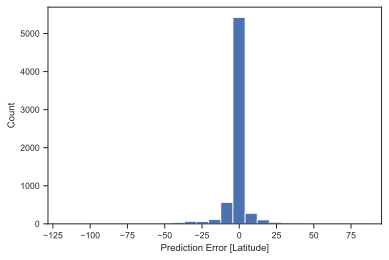

In [32]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Latitude]')
_ = plt.ylabel('Count')

In [33]:
# make a single prediction
import time
from datetime import datetime
mag = float(input('Enter a magnitude: '))
lon = float(input('Enter a longitude (in decimal form; negative for west of meridian): '))
depth = float(input('Enter a depth (in km, only numerical value): '))
date_input = input('Enter a date (yyyy/mm/dd): ')
time_input = input('Enter a time in UTC (HH:MM:SS): ')
datetime_str = date_input + ' '+ time_input
date_time_obj = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M:%S')
date_time_unix = (time.mktime(date_time_obj.timetuple()))
single_features = [[mag,lon,depth,date_time_unix]]
y_pred = dnn_model.predict(single_features)
print('Predicted Latitude: %g' % y_pred)

Predicted Latitude: -122.799


Test with new data from USGS

In [34]:
#obtain USGS data for the day
page_url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_day.csv"

test_df = pd.read_csv(page_url)
test_df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-03-31T04:22:15.310Z,38.772835,-122.737831,0.97,2.0,md,39.0,71.0,0.01513,0.05,...,2022-03-31T04:28:16.788Z,"2km ESE of The Geysers, CA",earthquake,0.2,0.3,0.110,10.0,automatic,nc,nc
1,2022-03-31T04:11:50.151Z,62.093100,-151.438300,71.90,2.2,ml,NaN,NaN,NaN,0.53,...,2022-03-31T04:21:07.969Z,"11 km N of Skwentna, Alaska",earthquake,NaN,0.7,NaN,NaN,automatic,ak,ak
2,2022-03-31T04:09:44.770Z,30.593700,50.029800,10.00,4.7,mb,NaN,78.0,5.78600,0.92,...,2022-03-31T04:28:39.040Z,"20 km W of Behbahān, Iran",earthquake,6.6,1.9,0.067,68.0,reviewed,us,us
3,2022-03-31T04:08:05.117Z,59.860300,-153.290700,118.50,2.6,ml,NaN,NaN,NaN,0.70,...,2022-03-31T04:18:35.468Z,"46 km E of Pedro Bay, Alaska",earthquake,NaN,0.4,NaN,NaN,automatic,ak,ak
4,2022-03-31T04:07:50.432Z,62.190800,-148.259000,29.20,1.3,ml,NaN,NaN,NaN,0.69,...,2022-03-31T04:16:45.816Z,"45 km NNE of Chickaloon, Alaska",earthquake,NaN,0.2,NaN,NaN,automatic,ak,ak


In [35]:
#create unix time column
test_df['Unix Time'] = pd.to_datetime(test_df['time']).astype(int)/10**9

In [36]:
#dropped columns not needed
cleaned_test_df = test_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_test_df

,latitude,longitude,depth,mag,Unix Time
0,38.772835,-122.737831,0.97,2.00,1.648701e+09
1,62.093100,-151.438300,71.90,2.20,1.648700e+09
2,30.593700,50.029800,10.00,4.70,1.648700e+09
3,59.860300,-153.290700,118.50,2.60,1.648700e+09
4,62.190800,-148.259000,29.20,1.30,1.648700e+09
...,...,...,...,...,...
251,58.258167,-154.929167,4.41,-0.76,1.648616e+09
252,58.251333,-154.916167,13.43,-0.81,1.648615e+09
253,36.163167,-118.022833,2.96,1.98,1.648615e+09
254,3.422900,126.774500,35.00,4.60,1.648615e+09


In [37]:
#find if any column has NaNs
cleaned_test_df.isnull().sum()

latitude     0
longitude    0
depth        0
mag          0
Unix Time    0
dtype: int64

In [38]:
test_features1 = cleaned_test_df.copy()

test_labels1 = test_features1.pop('latitude')

In [39]:
test_predictions2 = dnn_model.predict(test_features1).flatten()

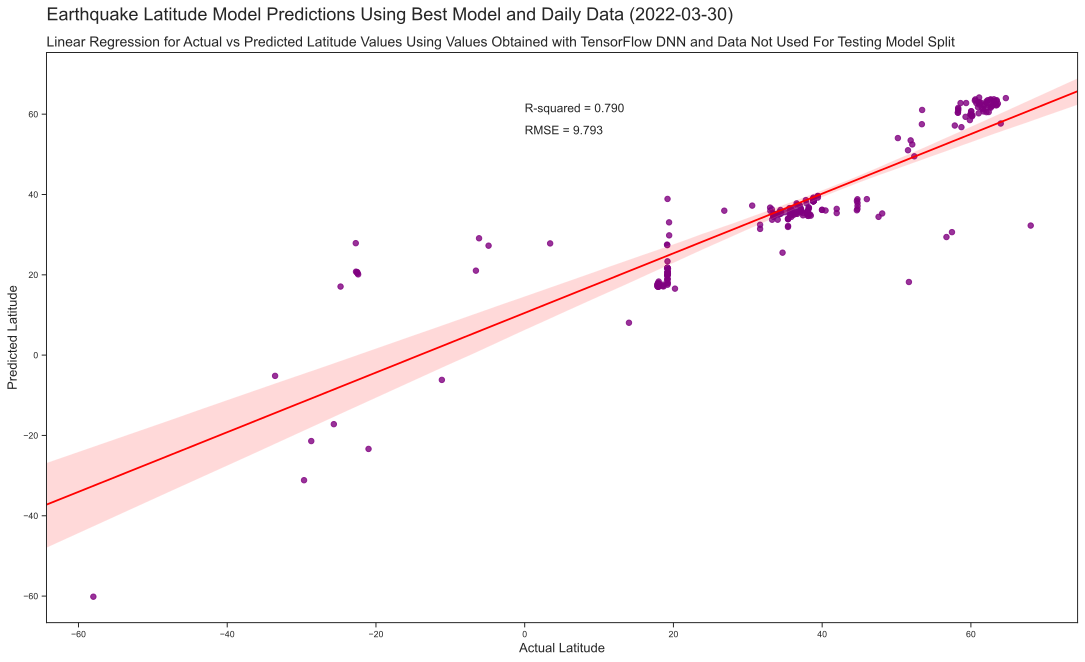

In [41]:
#create grpah for actual vs predicted values
from datetime import date
today = date.today()

x = np.array(test_labels1)
y = np.array(test_predictions2)
test_mse = mean_squared_error(test_labels1,test_predictions2)
rmse = sqrt(test_mse)

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'purple'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Latitude', fontsize=13)
plt.xlabel('Actual Latitude',  fontsize=13)
# Bigger title
plt.suptitle(f'Earthquake Latitude Model Predictions Using Best Model and Daily Data ({today})', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Latitude Values Using Values Obtained with TensorFlow DNN and Data Not Used For Testing Model Split', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(test_labels1, test_predictions2)), (0, 60.5),  fontsize=12)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 55), fontsize=12)

fig.savefig('../static/images/NN_lat_linear_sns_daily.png', bbox_inches='tight', dpi=600)
plt.show()